In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import joblib

In [3]:
BASE_DIR = os.getcwd()

TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR  = os.path.join(BASE_DIR, "test")

print("Base directory:", BASE_DIR)
print("Train directory:", TRAIN_DIR)
print("Test directory:", TEST_DIR)

Base directory: c:\Users\rawan\Desktop\fruit_veg_classifier
Train directory: c:\Users\rawan\Desktop\fruit_veg_classifier\train
Test directory: c:\Users\rawan\Desktop\fruit_veg_classifier\test


In [4]:
feature_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    pooling="avg"   # 1280-D feature vector
)

print("MobileNetV2 loaded successfully")


C:\Users\rawan\AppData\Local\Temp\ipykernel_32772\1865406272.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  feature_model = MobileNetV2(


MobileNetV2 loaded successfully


In [5]:
def extract_feature(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    feature = feature_model.predict(img_array, verbose=0)
    return feature.flatten()


In [6]:
def process_folder(base_path):
    X, y_stage1, y_class = [], [], []

    for category in ["fruit", "vegetable"]:
        category_path = os.path.join(base_path, category)

        for class_name in os.listdir(category_path):
            class_path = os.path.join(category_path, class_name)
            if not os.path.isdir(class_path):
                continue

            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    X.append(extract_feature(img_path))
                    y_stage1.append(0 if category == "fruit" else 1)
                    y_class.append(class_name)
                except:
                    print("Failed:", img_path)

    return np.array(X), np.array(y_stage1), np.array(y_class)


In [7]:
X_train, y_train, y_train_class = process_folder(TRAIN_DIR)

np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("y_train_class.npy", y_train_class)

print("Training data prepared:", X_train.shape)

c:\Users\rawan\.conda\envs\ai_env\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training data prepared: (3115, 1280)


In [8]:
X_test, y_test, y_test_class = process_folder(TEST_DIR)

np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)
np.save("y_test_class.npy", y_test_class)

print("Testing data prepared:", X_test.shape)

Testing data prepared: (359, 1280)


In [9]:
rf_stage1 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_stage1.fit(X_train, y_train)

y_pred = rf_stage1.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Stage 1 Accuracy: {acc*100:.2f}%")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

joblib.dump(rf_stage1, "stage1_rf_model.pkl")


Stage 1 Accuracy: 95.82%
Confusion Matrix:
 [[ 74  15]
 [  0 270]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91        89
           1       0.95      1.00      0.97       270

    accuracy                           0.96       359
   macro avg       0.97      0.92      0.94       359
weighted avg       0.96      0.96      0.96       359



['stage1_rf_model.pkl']

In [10]:
fruit_idx_train = np.where(y_train == 0)[0]
veg_idx_train   = np.where(y_train == 1)[0]

fruit_idx_test = np.where(y_test == 0)[0]
veg_idx_test   = np.where(y_test == 1)[0]

X_train_fruit = X_train[fruit_idx_train]
y_train_fruit = y_train_class[fruit_idx_train]

X_test_fruit = X_test[fruit_idx_test]
y_test_fruit = y_test_class[fruit_idx_test]

X_train_veg = X_train[veg_idx_train]
y_train_veg = y_train_class[veg_idx_train]

X_test_veg = X_test[veg_idx_test]
y_test_veg = y_test_class[veg_idx_test]


In [11]:
fruit_model = RandomForestClassifier(n_estimators=100, random_state=42)
fruit_model.fit(X_train_fruit, y_train_fruit)

y_pred_fruit = fruit_model.predict(X_test_fruit)

print(f"Fruit Accuracy: {accuracy_score(y_test_fruit, y_pred_fruit)*100:.2f}%")
print(confusion_matrix(y_test_fruit, y_pred_fruit))
print(classification_report(y_test_fruit, y_pred_fruit))

joblib.dump(fruit_model, "fruit_type_model.pkl")


Fruit Accuracy: 86.52%
[[ 9  1  0  0  0  0  0  0  0]
 [ 0  8  0  0  1  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0]
 [ 0  0  0  4  5  0  0  0  1]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10]]
              precision    recall  f1-score   support

       apple       1.00      0.90      0.95        10
      banana       0.89      0.89      0.89         9
      grapes       1.00      1.00      1.00        10
        kiwi       0.71      1.00      0.83        10
       mango       0.62      1.00      0.77        10
      orange       0.00      0.00      0.00        10
   pineapple       1.00      1.00      1.00        10
 pomegranate       1.00      1.00      1.00        10
  watermelon       0.91      1.00      0.95        10

    accuracy                           0.87        89
   macro avg       0.79      0.87      0.82        89
weighted avg       0.79      0.87      0.82        89



c:\Users\rawan\.conda\envs\ai_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rawan\.conda\envs\ai_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rawan\.conda\envs\ai_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


['fruit_type_model.pkl']

In [12]:
veg_model = RandomForestClassifier(n_estimators=100, random_state=42)
veg_model.fit(X_train_veg, y_train_veg)

y_pred_veg = veg_model.predict(X_test_veg)

print(f"Vegetable Accuracy: {accuracy_score(y_test_veg, y_pred_veg)*100:.2f}%")
print(confusion_matrix(y_test_veg, y_pred_veg))
print(classification_report(y_test_veg, y_pred_veg))

joblib.dump(veg_model, "veg_type_model.pkl")


Vegetable Accuracy: 97.78%
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  1  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 1  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
   0  0  0]
 [ 0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  

['veg_type_model.pkl']

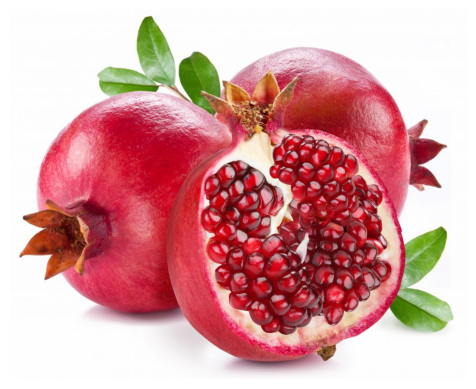

Category: Fruit
Predicted Type: pomegranate


In [13]:
def predict_image(img_path):
    img = load_img(img_path)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    feature = extract_feature(img_path).reshape(1, -1)
    stage1 = rf_stage1.predict(feature)[0]

    if stage1 == 0:
        label = fruit_model.predict(feature)[0]
        print("Category: Fruit")
    else:
        label = veg_model.predict(feature)[0]
        print("Category: Vegetable")

    print("Predicted Type:", label)

# Example test image (portable path)
sample_img = os.path.join(
    TEST_DIR, "fruit", "pomegranate", "Image_5.jpg"
)

predict_image(sample_img)